## Quadrature-based Bell-inequality violations in NEMS: Figure 3 and 4

J.R. Johansson and N. Lambert

This IPython notebook contains the numerical calculations that were performed to generating Fig. 3 and 4 in "Entangled-state generation and Bell inequality violations in nanomechanical resonators" ([arXiv:1402.4900](http://arxiv.org/abs/1402.4900)). The simulations were carried out using [QuTiP: Quantum Toolbox in Python](http://www.qutip.org).

In [1]:
%matplotlib inline

In [2]:
from qutip import *

In [3]:
from belltests import *

## Parameters

In [4]:
N1 = 10
N2 = 10

delta_0 = 0.0

gamma_1 = gamma_2 = 0
gamma_0 = 1.0

n_th = n_1_th = n_2_th = 0.0

kappa = 0.15

t_unit = 1/(kappa**2 / gamma_0)
tlist = linspace(0, 6*t_unit, 100)
t_idx_vec = [0, 30, 40, 50, 70, 99]

In [5]:
# optimal r
r = 1.12  

# optimal driving strength
E = r**2 * kappa / 2
E

0.09408000000000001

## Dynamics solver

In [6]:
a1 = tensor(destroy(N1), qeye(N2))
a2 = tensor(qeye(N1), destroy(N2))
vacuum = tensor(basis(N1), basis(N2))

def dynamics_solve(E):
        
    n_1_th = n_2_th = n_th    
    
    Delta_0 = 0
    gamma = kappa**2 * (gamma_0/2) / (abs(gamma_0/2 + 1j * Delta_0)**2)
    chi = - kappa**2 * Delta_0 / (abs(gamma_0/2 + 1j * Delta_0)**2)
    mu = E * kappa / (gamma_0 / 2 + 1j * Delta_0) 
    
    # 2 mode PA Hamiltonian
    H = 1j * (- a1 * a2 * conjugate(mu) + a1.dag() * a2.dag() * mu) + chi * a1.dag() * a2.dag() * a1 * a2

    # start in a thermal state
    psi = tensor([thermal_dm(N1, n_1_th), thermal_dm(N2, n_2_th)])  
    
    # setup collapse operators. only include those with nonzero rates (depends on n_*_th and kappa_*)
    c_ops_raw = [[sqrt(gamma_1 * (1+n_1_th)), a1], 
                 [sqrt(gamma_1 * n_1_th)    , a1.dag()], 
                 [sqrt(gamma_2 * (1+n_2_th)), a2], 
                 [sqrt(gamma_2 * n_2_th)    , a2.dag()],
                 [sqrt(gamma), a1 * a2]]
    
    c_ops = []
    for rate, op in c_ops_raw:
        if rate > 0.0:
            c_ops.append(rate * op)
        
    e_ops = []
        
    result = mesolve(H, psi, tlist, c_ops, e_ops)
    
    return result, H, c_ops

In [7]:
result, H, c_ops = dynamics_solve(E)

## Steady state

In [8]:
rhoss = steadystate(H, c_ops, method='iterative-bicg', use_precond=False, use_rcm=False)

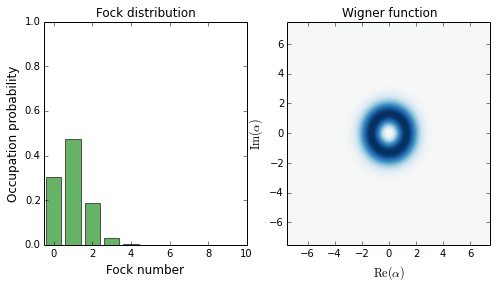

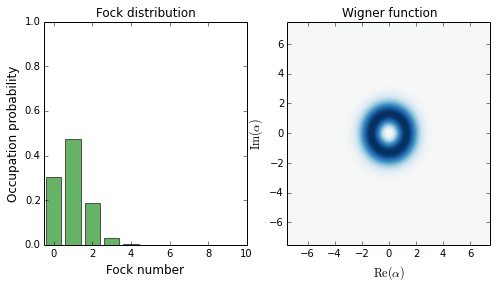

In [9]:
# compare the states of the signal and idler mode: they should be identical
wigner_fock_distribution(rhoss.ptrace(0));
wigner_fock_distribution(rhoss.ptrace(1));

## Squeezing vs time

In [10]:
matplotlib.rcParams.update({'font.size': 16, 'font.family': 'serif'})

In [11]:
xvec = linspace(-5, 5, 100)

In [12]:
rho = rhoss  # work with the steady state

computing M1 and M2


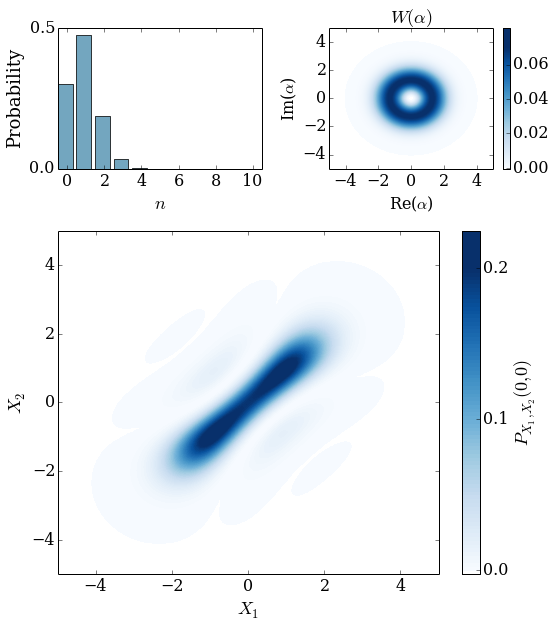

In [13]:
fig = figure(figsize=(8,9))

axes = [ subplot2grid((3,2), (0,0)),
         subplot2grid((3,2), (0,1)),
         subplot2grid((3,2), (1,0), colspan=2, rowspan=2) ]

psi_a = ptrace(rho, 0)

cmap=get_cmap('Blues', lut=250)
cmap.set_under("white")

# Fock distribution
axes[0].bar(arange(N1)-0.5, real(psi_a.diag()), color="#4488AA", width=0.8, alpha=0.75)
axes[0].set_xlabel(r"$n$", fontsize=18)
axes[0].set_ylabel(r"Probability", fontsize=18)
axes[0].set_ylim(0, 0.5)
axes[0].set_xlim(-0.5, 10.5)
axes[0].set_yticks([0.0, 0.5])

# Wigner function
W_a = wigner(psi_a, xvec, xvec)
W_a[W_a < 0] = 0
norm=mpl.colors.Normalize(0, 0.08) 
c = axes[1].contourf(xvec, xvec, W_a-0.00001, 250, cmap=cmap, norm=norm, vmin=0, vmax=0.08)
axes[1].set_ylabel(r"Im($\alpha$)")
axes[1].set_xlabel(r"Re($\alpha$)")
cb = fig.colorbar(c, ax=axes[1], norm=norm)
cb.set_clim(0, 0.07)
cb.set_ticks([0.0, 0.02, 0.04, 0.06])
axes[1].set_title(r"$W(\alpha)$", fontsize=18)

# Quadrature-correlation
P2 = P_x1x2(xvec, xvec, 0.0, 0.0, rho)
P2[P2 < 0] = 0
norm=mpl.colors.Normalize(0, 0.20)
c = axes[2].contourf(xvec, xvec, P2-0.00001, 100, cmap=cmap, norm=norm)
axes[2].set_xlabel(r"$X_1$", fontsize=18)
axes[2].set_ylabel(r"$X_2$", fontsize=18)
cb = fig.colorbar(c, ax=axes[2], norm=norm)
cb.set_clim(0, 0.2)
cb.set_ticks([0.0, 0.1, 0.2])
cb.set_label(r"$P_{X_1,X_2}(0, 0)$", fontsize=18)
cb.changed()

fig.tight_layout();

In [14]:
fig.savefig("fig-3.pdf")
fig.savefig("fig-3.png")

### Single and two mode squeezing

In [15]:
a, b = a1, a2

In [16]:
matplotlib.rcParams.update({'font.size': 12, 'font.family': 'serif'})

In [17]:
# pre-compute operators outside the loop
x1 = (a + a.dag())/sqrt(2)
p1 = -1j*(a - a.dag())/sqrt(2)

x2 = (b + b.dag())/sqrt(2)
p2 = -1j*(b - b.dag())/sqrt(2)

n1 = a.dag() * a
n2 = b.dag() * b

R = [x1, p1, x2, p2]

n = zeros((2,len(tlist)))
e = zeros((4,len(tlist)))
v = zeros((4,len(tlist)))

v2 = zeros((4,len(tlist)))

for idx, psi in enumerate(result.states):
    n[0, idx] = expect(n1, psi)
    n[1, idx] = expect(n2, psi)

    v[0, idx] = variance(x1, psi)
    v[1, idx] = variance(p1, psi)
    v[2, idx] = variance(x2, psi)
    v[3, idx] = variance(p2, psi)

    v2[0, idx] = variance(x1-x2, psi)
    v2[1, idx] = variance(x1-p2, psi)
    v2[2, idx] = variance(p1-x2, psi)
    v2[3, idx] = variance(p1-p2, psi)
    

In [18]:
R2_op = correlation_matrix_quadrature(a1, a2)

/home/rob/py-envs/py3-stable/lib/python3.3/site-packages/qutip/continuous_variables.py:287: RuntimeWarning: invalid value encountered in sqrt
  nu_ = sigma / 2 - np.sqrt(sigma ** 2 - 4 * np.linalg.det(V)) / 2


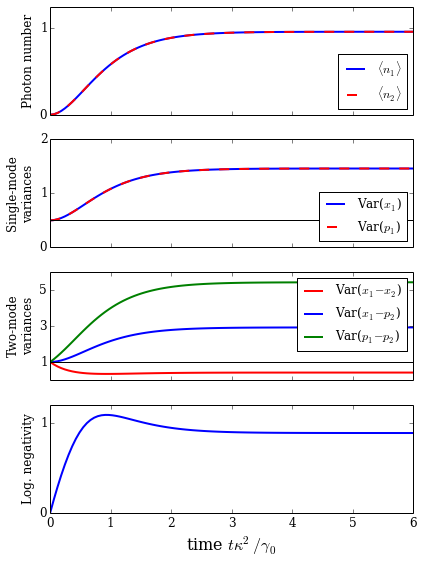

In [19]:
fig, axes = subplots(4, 1, figsize=(6,8), sharex=True)

# photon number
l, = axes[0].plot(tlist/t_unit, n[0,:], 'b', label=r"$\langle n_1 \rangle$", lw=2)
l, = axes[0].plot(tlist/t_unit, n[1,:], 'r', label=r"$\langle n_2 \rangle$", lw=2)
l.set_dashes([10, 10]) 
axes[0].set_ylabel("Photon number")
axes[0].legend(prop={'size': 12}, loc=4)
axes[0].set_ylim(0,1.25)
axes[0].set_yticks([0,  1.0])

# single-mode variance
axes[1].set_ylabel("Single-mode\nvariances")
l, = axes[1].plot(tlist/t_unit, v[0,:], 'b', label="Var($x_1$)", lw=2)
l, = axes[1].plot(tlist/t_unit, v[1,:], 'r', label="Var($p_1$)", lw=2)
l.set_dashes([10, 10]) 
axes[1].plot(tlist/t_unit, variance(x1, vacuum) * ones(shape(tlist)), 'k') 
axes[1].legend(prop={'size': 12}, loc=4) 
axes[1].set_ylim(0,2)
axes[1].set_yticks([0, 1.0, 2.0])

# two-mode variance
axes[2].set_ylabel("Two-mode\nvariances")
axes[2].plot(tlist/t_unit, v2[0,:], 'r', label="Var($x_1-x_2$)", lw=2)
axes[2].plot(tlist/t_unit, v2[1,:], 'b', label="Var($x_1-p_2$)", lw=2)
axes[2].plot(tlist/t_unit, v2[3,:], 'g', label="Var($p_1-p_2$)", lw=2)
axes[2].plot(tlist/t_unit, 2*variance(x1, vacuum) * ones(shape(tlist)), 'k')
axes[2].legend(prop={'size': 12})
axes[2].set_yticks([1, 3, 5])

# negativity
logneg = zeros(shape(tlist))
for idx, t_idx in enumerate(tlist):
    V2 = wigner_covariance_matrix(R=R2_op, rho=result.states[idx])
    logneg[idx] = logarithmic_negativity(V2)

axes[3].set_ylabel("Log. negativity")
axes[3].plot(tlist/t_unit, logneg, 'b', label="E_N", lw=2)
axes[3].set_xlabel(r"time $t\kappa^2/\gamma_0$", fontsize=16)
axes[3].set_yticks([0, 1])

fig.tight_layout()

In [20]:
fig.savefig("fig-4.pdf")

## Software versions

In [22]:
%reload_ext version_information
%version_information numpy, scipy, matplotlib, qutip

Software versions
Python 3.3.2+ (default, Oct  9 2013, 14:50:09) [GCC 4.8.1]
IPython 1.2.0
OS posix [linux]
numpy 1.8.0
scipy 0.13.3
matplotlib 1.3.1
qutip 3.0.0.dev-3a29ba5
<tr><td colspan='2'>Mon Mar 03 16:50:13 2014 JST</td></tr>